<a href="https://colab.research.google.com/github/GustavoBD-Dev/neuronalnetworks/blob/main/ClasificadorDeImagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de imagenes con redes neuronales
Se elabora una red neuronal que consta de 784 neuronas de entrada, las cuales corresponden a los pixeles de la imagen, dos capas ocultas de 50 neuronas cada una y una capa de salida con 10 neuronas que corresponden a las categorias.

Importamos las librerias de tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

EL set de datos podemos descargarlo de la libreria `tensorflow_datasets`. Para realizar la descarga de todos los metadatos es necesario especificar los argumentos `as_supervised` y `with_info` en `True`.

In [3]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYUDQJL/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYUDQJL/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Imprimimos los medatatos, aqui se despliegua la informacion del set que se ha descargado. Se aprecia que en el set se tienen 70000 imagenes, de los cuales 60000 son para entrenamiento y 10000 son para prueba.

In [4]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

Separamos los conjuntos en variables diferentes para utilizarlas.

In [5]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

Obtenemos los nombres de las variables o clases del set de datos

In [6]:
nombre_clases = metadatos.features['label'].names
nombre_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

##Normalizamos los datos 
Pasar de 0-255 a 0-1, ya que los valores de los pixeles se encuentran de en un intervalo de 0 - 255.

In [7]:
# Normalizar los datos
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui los pasa de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar a cache (usar memoria en lugar de disco, entrenamiento rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()


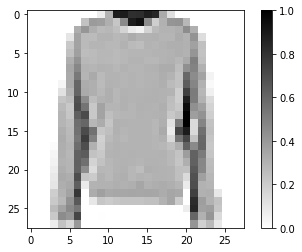

In [9]:
# Mostrar la imagen de los datos de pruebas (primer imagen)
for imagen, etiqueta in datos_entrenamiento.take(1):
  break

imagen = imagen.numpy().reshape((28,28)) # Redimensionar (Tensores)

import matplotlib.pyplot as plt

# Dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Mostramos las imagenes con la categoria correcta con la que esta etiquetada

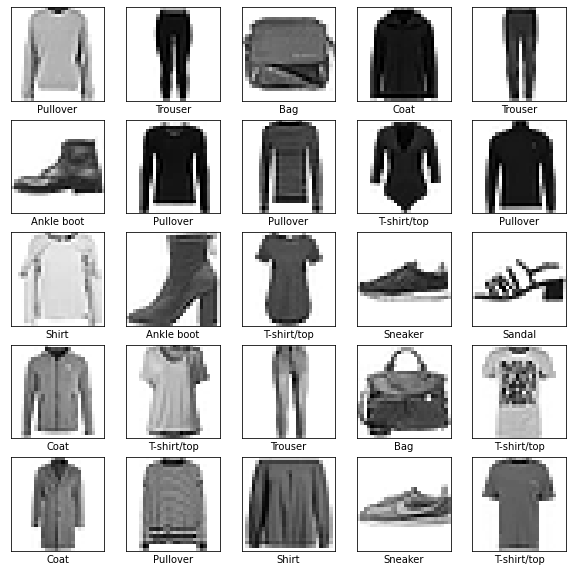

In [12]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])
plt.show()

## Modelo: red tipo secuencial
*Capa de entrada* de tipo `Flatten`, que recibe la iamgen de 28x28 en blanco y negro


In [13]:
# crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), # 1 - banco y negro
  # dos capas ocultas con 50 neuronas y funcion de activacion ReLu
  tf.keras.layers.Dense(50, activation=tf.nn.relu), 
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  # capa de salida, softmax asegura que la suma de las neuronas finales sea 1
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
])

## Compilamos el modelo
Para una ejecucion mas rapido se realiza en lotes con tamaño 32, de una forma aleatoria con las funciones `repeat` y `shuffle`. Con la funcion `batch` se establece el tamaño del lote de entrenamiento.

In [15]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [18]:
TAMANO_LOTE = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_prueba = datos_pruebas.batch(TAMANO_LOTE)

## ENTRENAMIENTO
Para relizar el entrenamiento utilizamos la funcion `fit` en la cual establecemos los datos de entrenamiento, el numero de vueltas y pasos por epoca. 

In [19]:
import math

# Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 11s 2ms/step - loss: 0.5147 - accuracy: 0.8183
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3770 - accuracy: 0.8631
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3444 - accuracy: 0.8739
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3267 - accuracy: 0.8801
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3132 - accuracy: 0.8843


Graficamos la magnitud de perdida

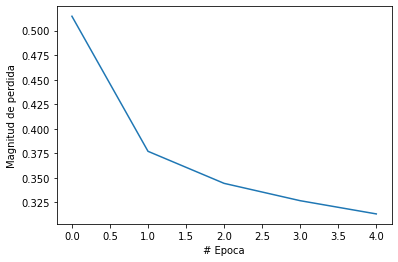

In [20]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

## Pedicción

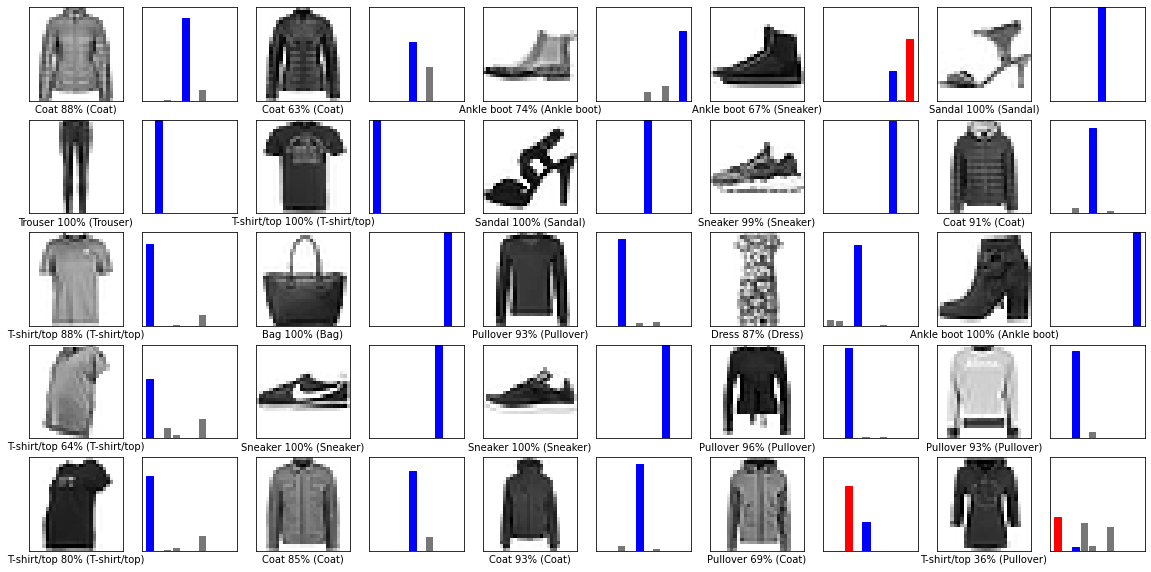

In [22]:
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiquetas_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiquetas_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(
      nombre_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombre_clases[etiquetas_real],
      color=color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiquetas_real):
  arr_predicciones, etiquetas_real = arr_predicciones[i], etiquetas_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0,1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiquetas_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

Prediccion de cualquier dato del set de pruebas

In [29]:
imagen = imagenes_prueba[2]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)
print("Predicción: " + nombre_clases[np.argmax(prediccion[0])])

Predicción: Ankle boot
